## Drowsiness detection algorithm using the pre-trained model from Mobilenet

In [1]:
# Import dependencies
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random

## Explore the data

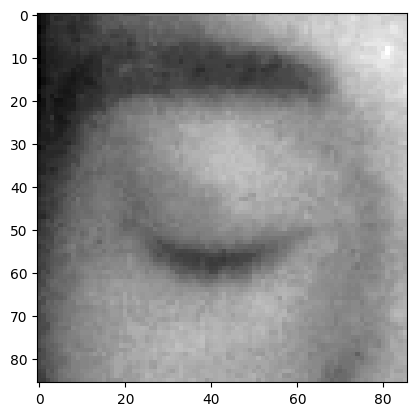

In [5]:
# Look at a single image of the training data
img_array = cv2.imread('./train/Closed_Eyes/s0001_00001_0_0_0_0_0_01.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img_array, cmap="gray")  

## See the size of the data

In [7]:
Datadirectory = './train'
Classes = ['Closed_Eyes', 'Open_Eyes']

# For each of the categories
for category in Classes:
  # Get the path to the category
  path = os.path.join(Datadirectory, category)
  
  # Print the amount of images in the category
  print(f'{category} category has {len(os.listdir(path))} images')
  
  # Print the maximal size of the images
  print('The images have a size of:')
  min_size = 10000
  max_size = 0
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
    
    if img_array.shape[0] < min_size:
      min_size = img_array.shape[0]
      
    if img_array.shape[0] > max_size:
      max_size = img_array.shape[1]
      
  # Print the minimal size of the images
  print(f' The minimal size of {category} is {min_size} x {min_size}')
  
  # Print the maximal size of the images
  print(f' The maximal size of {category} is {max_size} x {max_size}')
  
  print()

Closed_Eyes category has 2000 images
The images have a size of:
 The minimal size of Closed_Eyes is 65 x 65
 The maximal size of Closed_Eyes is 180 x 180

Open_Eyes category has 2000 images
The images have a size of:
 The minimal size of Open_Eyes is 60 x 60
 The maximal size of Open_Eyes is 179 x 179



## Create training data

In [12]:
# Define the size of each the input images
images_size = 224

In [8]:
# Create the training data for each of the classes
def create_training_data(training_data, size_of_images=images_size):
    # For each of the categories
    for category in Classes:
        # Get the path to the category
        path = os.path.join(Datadirectory, category)
        
        # Get the index of the class, 0 for closed eyes and 1 for open eyes
        class_index = Classes.index(category)
        
        # For each image first conert it to the size and grayscale, then add it to the training data
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
            backtorgb = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
            new_array = cv2.resize(backtorgb, (size_of_images, size_of_images))
            training_data.append([new_array, class_index])
            
    return training_data
            
# Create the training dataset using shuffled samples
training_data = create_training_data([])

In [49]:
# Get the size of the training data
print(len(training_data))

4000


In [50]:
# Shuffle the data
import random
random.shuffle(training_data)

In [51]:
#here we reshape the image.
X = []
y = []

# For each feature and label in the training data
for features, label in training_data:
  X.append(features)
  y.append(label)

# Reshape the features into a numpy array that works with tensorflow
X = np.array(X).reshape(-1, images_size, images_size, 3)

# Normalize the features
X = X/255.0

# Convert the labels to a numpy array that works with tensorflow
Y = np.array(y)

## Creating the model using a pre-trained model

In [52]:
model = tf.keras.applications.mobilenet.MobileNet()

In [53]:
# Get an idea of the model
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [60]:
# Get the input and output dimensions of the model
input_shape = model.layers[0].input
output_shape = model.layers[-4].output

In [61]:
Flat_layer = layers.Flatten()(output_shape)
final_output = layers.Dense(1)(Flat_layer)
final_output = layers.Activation('sigmoid')(final_output)
model = keras.Model(inputs = input_shape, outputs = final_output)
model.summary()

# Compile the model using adam as optimizer and binary crossentropy as loss function
model.compile(loss="binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

# Fit the model on the training data using two epochs and a validation split of 10%
model.fit(X, Y, epochs = 2, validation_split = 0.1)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       


                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128       
 zation)                                                         
                                                                 
 conv_dw_1_relu (ReLU)       (None, 112, 112, 32)      0         
                                                                 
 conv_pw_1 (Conv2D)          (None, 112, 112, 64)      2048      
          

## Test the model on a new dataset

In [2]:
# Download the model that we trained
model = keras.models.load_model('model.h5')

## Explore one sample from the test set and see how we get the eyes from the images

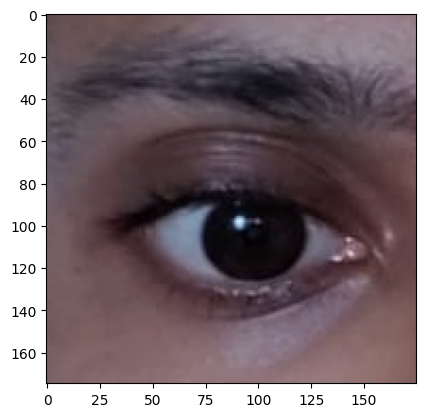

In [3]:
# Look at a test image
img = cv2.imread(f'test_2/Open_eyes/_0.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

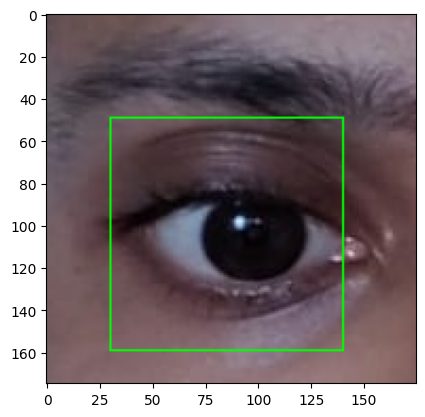

In [4]:
# Get the cascade classifier for the face and eyes
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')
eyeCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
eyes = eyeCascade.detectMultiScale(gray, 1.1, 4)

# For each of the eyes draw a rectangle around them
for (x, y, w, h) in eyes:
  cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 1)
  
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [147]:
def detect_eyes(img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect the eyes
    eyes = eyeCascade.detectMultiScale(gray, 1.28, 4)
    found = False

    # For each of the eyes draw a rectangle around them
    for x, y,w, h in eyes:
        roi_gray = gray[y:y + h, x:x + w]
        roi_color = img[y:y + h, x:x + w]
        eyes_cv = eyeCascade.detectMultiScale(roi_gray)
        if len(eyes_cv) != 0:
            for ex, ey, ew, eh in eyes_cv:
                found = True
                eyes_roi = roi_color[ey:ey+eh, ex:ex+ew]

    # In case the eyes are not detected return -1
    if found:
        return eyes_roi
    else:
        return img

## Create the test dataset 1 (zoomed in on the eye)

In [148]:
# Create the test data for each of the classes
def create_test_data(test_data, test_directory, eye_detection = False):
    # For each of the categories
    for category in Classes:
        # Get the path to the category
        path = os.path.join(test_directory, category)
        
        # Get the index of the class, 0 for closed eyes and 1 for open eyes
        class_index = Classes.index(category)
        
        # For each image first conert it to the size and grayscale, then add it to the training data
        for img in os.listdir(path):
            # Get the eyes in the image
            img = os.path.join(path, img)
            if eye_detection:
                img_array = cv2.imread(img)
                img_array = detect_eyes(img_array)
                backtorgb = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
            else:
                img_array = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
                backtorgb = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
            new_array = cv2.resize(backtorgb, (images_size, images_size))
            test_data.append([new_array, class_index])
            
    return test_data
            
# Create the training dataset
test_directory = 'test_2'
test_data = create_test_data([], test_directory)

In [149]:
# Shuffle the test data
X_test = []
y_test = []

# For each feature and label in the test data
for features, label in test_data:
  X_test.append(features)
  y_test.append(label)

# Reshape the features into a numpy array that works with tensorflow
X_test = np.array(X_test).reshape(-1, images_size, images_size, 3)

# Normalize the features
X_test = X_test/255.0

# Convert the labels to a numpy array that works with tensorflow
Y_test = np.array(y_test)

# Predict the class of the image
Y_pred = model.predict(X_test)


46/46 [==============================] - 4s 88ms/step


In [15]:
# Print the accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, Y_pred.round())
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.90%


## Test dataset 3, no zoom on eye

In [151]:
test_directory = 'test_3'
test_data = create_test_data([], test_directory, eye_detection = True)

In [152]:
# Shuffle the test data
X_test = []
y_test = []

# For each feature and label in the test data
for features, label in test_data:
  X_test.append(features)
  y_test.append(label)

# Reshape the features into a numpy array that works with tensorflow
X_test = np.array(X_test).reshape(-1, images_size, images_size, 3)

# Normalize the features
X_test = X_test/255.0

# Convert the labels to a numpy array that works with tensorflow
Y_test = np.array(y_test)

# Predict the class of the image
Y_pred = model.predict(X_test)

4/4 [==============================] - 0s 71ms/step


Accuracy: 51.00%


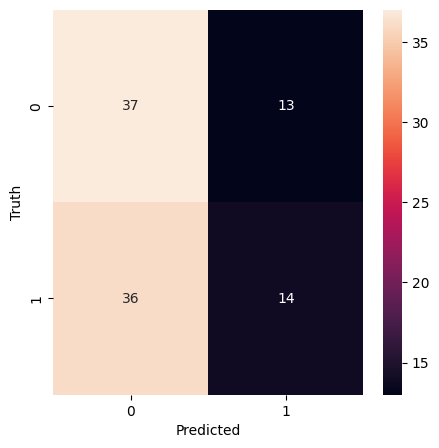

In [153]:
# Get the accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, Y_pred.round())
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Put down a matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, Y_pred.round())

# Plot it
import seaborn as sns
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [145]:
!pip install seaborn

   ---------------------------------------- 0.0/294.8 kB ? eta -:--:--
   --------------- ------------------------ 112.6/294.8 kB 6.8 MB/s eta 0:00:01
   ---------------------------------------- 294.8/294.8 kB 6.1 MB/s eta 0:00:00


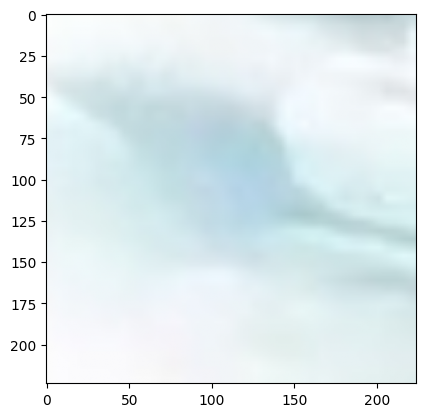

In [125]:
# show thez first sample image
plt.imshow(X_test[5])

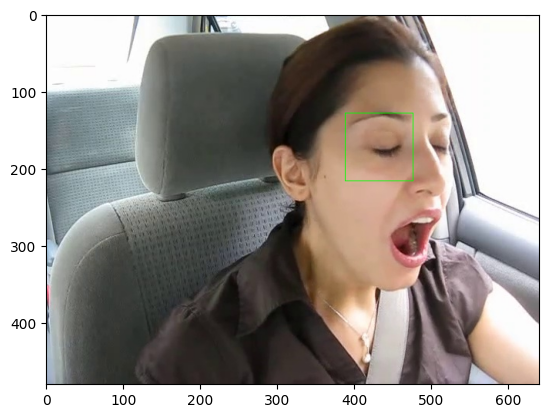

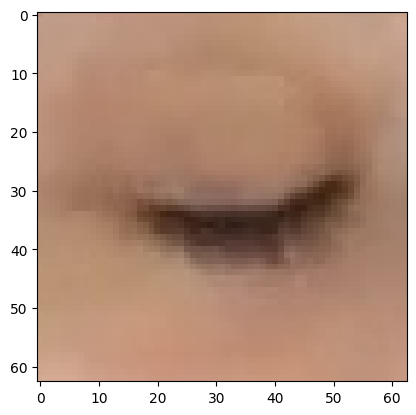

In [130]:
category = Classes[0]

# Get the path to the category
path = os.path.join("test_3", category)

# Get the index of the class, 0 for closed eyes and 1 for open eyes
class_index = 0

# For each image first conert it to the size and grayscale, then add it to the training data
img = os.listdir(path)[0]
img = os.path.join(path, img)
img_array = cv2.imread(img)

gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
eyes = eyeCascade.detectMultiScale(gray, 1.28, 4)

for (x, y, w, h) in eyes:
  cv2.rectangle(img_array, (x,y), (x+w, y+h), (0, 255, 0), 1)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
plt.show()

for x, y,w, h in eyes:
    roi_gray = gray[y:y + h, x:x + w]
    roi_color = img_array[y:y + h, x:x + w]
    eyes_cv = eyeCascade.detectMultiScale(roi_gray)
    if len(eyes_cv) != 0:
        for ex, ey, ew, eh in eyes_cv:
            eyes_roi = roi_color[ey:ey+eh, ex:ex+ew]
            plt.imshow(cv2.cvtColor(eyes_roi, cv2.COLOR_BGR2RGB))
            plt.show()
new_array = cv2.resize(eyes_roi, (images_size, images_size))
